# Cows Supplychain Network

In [46]:
# DEV 
from importlib import reload
from supply_chain_mapping import visualizations
from supply_chain_mapping import network_analysis
visualizations = reload(visualizations)
network_analysis = reload(network_analysis)

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd

# Show all columns when displaying tables
pd.set_option('display.max_columns', None)

from supply_chain_mapping import data_cleaning_and_processing as dc
from supply_chain_mapping import network_analysis as na
from supply_chain_mapping import visualizations as vz

from vcue.basics import full_pickle, loosen 
from vcue.visual import display_side_by_side
from vcue.data import order

***Load the data***:

In [47]:
%%time
graph_data = dc.get_network_data()

# The nodes are in Japanese which can cause some issues when exporting node names. 
# Encode the names with numbers and assign their unique numbers back to the data 
graph_data = graph_data.sort_values(['Individual Identification  Number','date_origin'])
unique_nodes = list(set(list(graph_data['origin'].unique()) + list(graph_data['destination'].unique())))
node_ids = dict(zip(unique_nodes, range(0,len(unique_nodes))))
graph_data['origin'] = graph_data['origin'].map(node_ids)
graph_data['destination'] = graph_data['destination'].map(node_ids)

print(graph_data.shape)
graph_data.head(2)

(600776, 15)
Wall time: 47.8 s


Individual Identification  Number  origin status_origin date_origin  \
82                          204069315   30442         Birth  2007-11-21   
83                          204069315   30442      Move-out  2008-08-18   

   Pref_origin  duration    age  destination status_destination  \
82        鹿児島県     271.0  271.0        30442           Move-out   
83        鹿児島県       0.0  271.0        18934        Carrying-in   

   date_destination Pref_destination  Unnamed: 0 異動内容 市区町村  movement_number  
82       2008-08-18             鹿児島県        1020   転出  鹿屋市                1  
83       2008-08-18             鹿児島県        1021   搬入  鹿屋市                2

# Sampling Strategy: Sample Movements in Time

Data on cows traversing the network cover multiple years. Nodes come and go across years and the data for the entire network over time is  too much to process at once, not to mention that and analysis of that sort would provide results that are difficult to interpret. 

**Sampling movements in times** is one of the options offered in the `na.sample_network` function (in this case, used in the `na.get_graphs_by_year` function). It uses the movements that took place in a window of time (1 or multiple years) to detect the network. Other sampling strategies are used in the other notebooks. 

***Sample Cow's slaughtered in each year and build networks based on the nodes and edges revealed by their trajectory***:

In [48]:
# Get the full list of years in the data and remove missing values 
years = graph_data['date_destination'].apply(lambda d: d.year).unique()
years = [int(y) for y in years if ~np.isnan(y) and y > 2010]
years.sort()

# Sample the network for each year and return non-directed graphs 
network_by_slaughter_year_full, graphs_by_slaughter_year_full, s_network_age_full = na.get_graphs_by_year(graph_data, years, sample_type='by_slaughter', directed=False, years_to_use=1, use_list_interval=True)

***Same as above but limit the number of cows sampled each year to create uniform samples***:
<br>We will use years after 2011 so we limit our sample to 3,000 IDs per year. 

In [49]:
na.num_ids_by_slaughter_year(graph_data)

# Ids in 2002 is 1138
# Ids in 2003 is 2246
# Ids in 2004 is 2929
# Ids in 2005 is 4367
# Ids in 2006 is 4757
# Ids in 2007 is 4990
# Ids in 2008 is 3850
# Ids in 2009 is 3224
# Ids in 2010 is 3199
# Ids in 2011 is 3242
# Ids in 2012 is 4006
# Ids in 2013 is 5607
# Ids in 2014 is 6129
# Ids in 2015 is 5577
# Ids in 2016 is 4595
# Ids in 2017 is 4250
# Ids in 2018 is 4229
# Ids in 2019 is 4053
# Ids in 2020 is 3783
# Ids in 2021 is 3217


In [50]:
# Sample the network for each year and return non-directed graphs 
# This will be the sampling method we base our analysis on so we use the get sample means option to get the mean age over time 
network_by_slaughter_year, graphs_by_slaughter_year, s_network_age, sample_means = na.get_graphs_by_year(graph_data, years, sample_type='by_slaughter', directed=False, years_to_use=1, use_list_interval=True, num_ids=3000, get_sample_means=True)

In [51]:
# This is the sample we'll use so 
# get the directred Graphs for directed graph analysis
digraph_by_slaughter_year, digraph_by_slaughter_year, s_digraph_age = na.get_graphs_by_year(graph_data, years, sample_type='by_slaughter', directed=True, years_to_use=1, use_list_interval=True)

***Sample movements in each year and build networks based on the nodes and edges revealed in these movements***:

In [52]:
%%time 
# Sample the network for each year and return non-directed graphs 
network_by_year, directed_graphs_by_year, network_age = na.get_graphs_by_year(graph_data, years, sample_type='by_year', directed=False, years_to_use=1, use_list_interval=1)

Wall time: 8.81 s


In [53]:
print('Sampled by Year             | by Slaughter Year         | Uniform Sample by Slaughter Year')
display_side_by_side(network_by_year[['Year','NumNodes','NumEdges']], 
                     network_by_slaughter_year_full[['Year','NumNodes','NumEdges']],
                     network_by_slaughter_year[['Year','NumNodes','NumEdges']])

Sampled by Year             | by Slaughter Year         | Uniform Sample by Slaughter Year


Year 
 NumNodes 
 NumEdges 
 
 
 
 
 0 
 2011 
 8022 
 16699 
 
 
 1 
 2012 
 9275 
 19469 
 
 
 2 
 2013 
 9351 
 20564 
 
 
 3 
 2014 
 8518 
 18730 
 
 
 4 
 2015 
 7604 
 16769 
 
 
 5 
 2016 
 6982 
 15272 
 
 
 6 
 2017 
 6733 
 14610 
 
 
 7 
 2018 
 6158 
 13507 
 
 
 8 
 2019 
 5712 
 12502 
 
 
 9 
 2020 
 3365 
 7317 
 
 
 10 
 2021 
 2206 
 4653 
 
 
 
 
 
 
 Year 
 NumNodes 
 NumEdges 
 
 
 
 
 0 
 2011 
 4659 
 11658 
 
 
 1 
 2012 
 5595 
 14087 
 
 
 2 
 2013 
 7723 
 19592 
 
 
 3 
 2014 
 8087 
 20547 
 
 
 4 
 2015 
 7628 
 19390 
 
 
 5 
 2016 
 6534 
 16484 
 
 
 6 
 2017 
 6100 
 15382 
 
 
 7 
 2018 
 5947 
 15171 
 
 
 8 
 2019 
 5862 
 14839 
 
 
 9 
 2020 
 5516 
 13971 
 
 
 10 
 2021 
 4857 
 12267 
 
 
 
 
 
 
 Year 
 NumNodes 
 NumEdges 
 
 
 
 
 0 
 2011 
 4412 
 11008 
 
 
 1 
 2012 
 4551 
 11317 
 
 
 2 
 2013 
 4858 
 12091 
 
 
 3 
 2014 
 4771 
 11873 
 
 
 4 
 2015 
 4815 
 12003 
 
 
 5 
 2016 
 4719 
 11726 
 
 
 6 
 2017 
 4706 
 11711 
 
 
 7 
 2018 
 4641 
 11652 
 
 
 8 
 2019 
 4682 
 11647 
 
 
 9 
 2020 
 4619 
 11554 
 
 
 10 
 2021 
 4605 
 11601

**Observations:** <br>
The example above shows that networks built by *sampling movements by year* is much more susceptible to availability of data by year (this is clear when compared to distribution of scraped data). However, networks built by *sampling cows by the year they were slaughtered* have a more consistent number of nodes and edges. This is especially true when we randomly sample the same number of cows each year. 

We can confirm that **data availability is not a serious concern when sampling by slaughter year with a uniform sample** because  every network is only about 3 to 5 years. Below is a table showing the number of movements that took place in the past for each sample year. 

In [ ]:
fig = vz.plot_network_ages(s_network_age, sample_means)
fig.show()

### <font color=red>*Note:*
<font color=red>*When examining the a single graph, we will use  ***2018*** as the base year because it the last normal year before the Covid-19 pandemic*

In [12]:
year_graph = graphs_by_slaughter_year[2018]

# Node Consistency Check

Node consistency describes how many nodes persist from year to year. How this might be affected by your sampling strategy (if your samples include overlapping time-windows for example). 

In [54]:
%%time
# Create a square, 3-dimensional matrix comparing the nodes in every year to the nodes in every other year
node_consistency_table = na.check_node_consistency(graphs_by_slaughter_year, years)

# Graph how nodes persist and vanish from the network over time 
vz.graph_node_consistency_by_year(node_consistency_table, years)

Wall time: 2.41 s


The graph above shows a year over year comparison. <br><br>
***We can check how many nodes from any given year were present in other years***:

In [14]:
base_year = 2018
for i in range(2011,2021):
    base_set = na.check_node_persistence_by_year(base_year,[i], graphs_by_slaughter_year)

1111 of 4641 nodes in the base year 2018 were present in all the comparison years 2011
1245 of 4641 nodes in the base year 2018 were present in all the comparison years 2012
1409 of 4641 nodes in the base year 2018 were present in all the comparison years 2013
1435 of 4641 nodes in the base year 2018 were present in all the comparison years 2014
1467 of 4641 nodes in the base year 2018 were present in all the comparison years 2015
1553 of 4641 nodes in the base year 2018 were present in all the comparison years 2016
1553 of 4641 nodes in the base year 2018 were present in all the comparison years 2017
4641 of 4641 nodes in the base year 2018 were present in all the comparison years 2018
1548 of 4641 nodes in the base year 2018 were present in all the comparison years 2019
1522 of 4641 nodes in the base year 2018 were present in all the comparison years 2020


# Community Detection 

In [55]:
fig, louvain_data, k_clique_data_3, louvain_c, k_clique_c_3 = vz.graph_community_attributes_over_time(graphs_by_slaughter_year, years, louvain = True,  k_clique_3 = True)
#fig, louvain_data, louvain_c = vz.graph_community_attributes_over_time(graphs_by_slaughter_year, years, louvain = True,  k_clique_3 = False)

In [56]:
fig.show()


***Retrieving the largest community for a given base year***:

In [58]:
base_year = 2018
year_graph = directed_graphs_by_year[base_year]

import networkx as nx
# Find the largest community in the base year 
communities = louvain_c[base_year]
largest_community = max(communities, key=lambda coll: len(coll))
largest_community_graph = year_graph.subgraph(largest_community)

In [60]:
# Not Implemented Graph 
#help(nx.nx_agraph.graphviz_layout)
#nx.nx_agraph.graphviz_layout(largest_community_graph, prog='circo')

# Fit Models 

In the `na.fit_year_graphs_to_models` function we calculate *# of nodes*, *# of links*, *<C>*, *<K>*, *<L>*, *disconnected*, *year* for the data and the data fitted to small-world, barabasi-albert and erdos-rosi models. 

In [61]:
base_year_graph = {}
base_year_graph[2018] = graphs_by_slaughter_year[2018]

In [ ]:
%%time
results_data, watts_strogatz_models, barabasi_albert_models, erdos_renyi_models = na.fit_year_graphs_to_models(network_by_slaughter_year[network_by_slaughter_year['Year']==2018],
                                                                                                               limited_graphs_by_slaughter_year)

In [103]:
results_data

# of nodes  # of link       <C>  \
empirical network                            4641      11652  0.037378   
small world (p=0.5787424185632628)           4641       9282  0.045261   
Barabasi-Albert (m=3)                        4641      13914  0.009069   
Erdős-Rényi (p=0.0010821835365445913)        4641      23617  0.001002   

                                             <K>       <L>  disconnected  year  
empirical network                       5.021332  4.602855             1  2018  
small world (p=0.5787424185632628)      4.000000  6.803894             0  2018  
Barabasi-Albert (m=3)                   5.996122  4.051405             0  2018  
Erdős-Rényi (p=0.0010821835365445913)  10.177548  5.282886             0  2018

In [ ]:
#results_data.to_csv('network_by_slaughter_year_results.csv')

In [62]:
results_data = pd.read_csv('network_by_slaughter_year_results.csv').rename(columns={'Unnamed: 0':'Model Type'})

In [63]:
results_data = results_data.sort_values('year')
results_data = results_data.set_index('Model Type')

In [65]:
# fig = vz.plot_model_fit_over_time(results_data)
# fig.show()

***Plot the degrees in & degrees out of the directed graph for a base-year***:

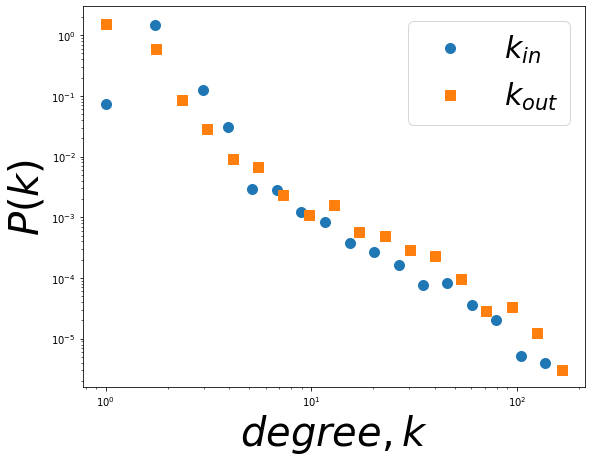

In [98]:
base_year = 2018
vz.plot_degrees_out_in_directedG(digraph_by_slaughter_year[base_year])

***Plot the degree distribution of the empirical model vs. other models to check best fit***:

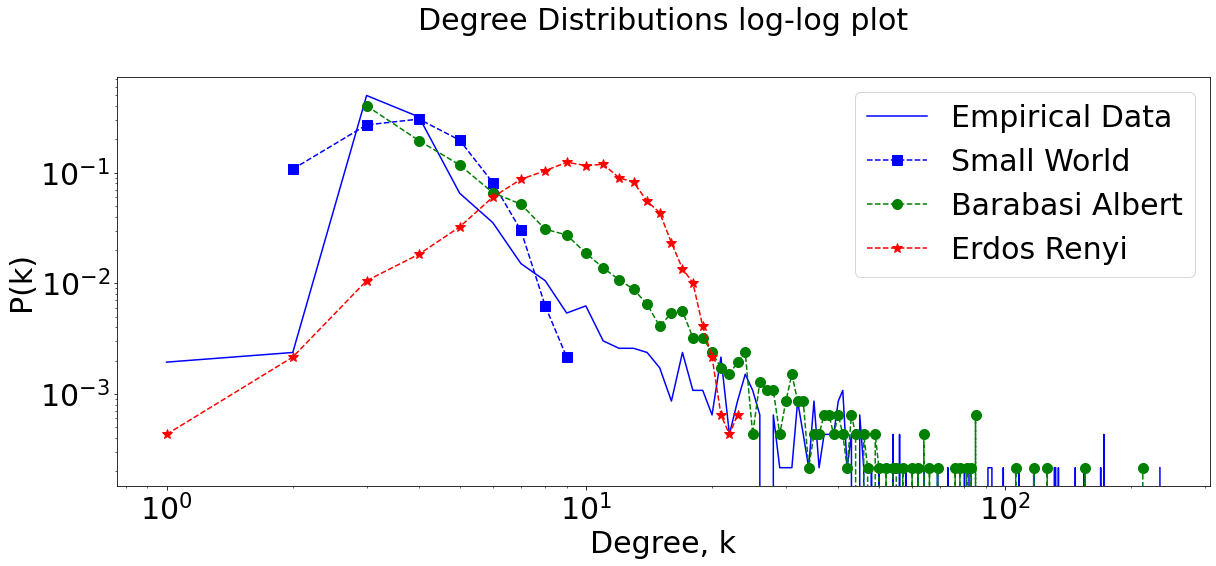

In [99]:
vz.loglogplot_model_degree_distribution(graphs_by_slaughter_year, watts_strogatz_models, barabasi_albert_models, erdos_renyi_models, base_year)

# Degree Centrality

In [68]:
%%time

base_year_digraph = {}
base_year_digraph[2018] = digraph_by_slaughter_year[2018]

# degcen_sequences, betcen_sequences, degree_centrality_over_time = na.degree_centrality_over_time(graphs_by_slaughter_year, years)
degcen_sequences, betcen_sequences, degree_centrality_over_time = na.degree_centrality_over_time(base_year_graph, [2018])

Wall time: 1min 46s


In [ ]:
# from vcue.basics import full_pickle, loosen 

# # full_pickle('degree_centralities_by_slaughter_year', degcen_sequences)
# # full_pickle('between_centralities_by_slaughter_year', betcen_sequences)
# # degree_centrality_over_time.to_csv('degree_centrality_over_time.csv')

# degcen_sequences = loosen('degree_centralities_by_slaughter_year.pickle')
# betcen_sequences = loosen('between_centralities_by_slaughter_year.pickle')
# degree_centrality_over_time = pd.read_csv('degree_centrality_over_time.csv')
# #degree_centrality_over_time = degree_centrality_over_time.rename(columns={'Unnamed: 0','year'})

# degree_centrality_over_time['Max Deg Centrality'] = [max(degcen_sequences[key]) for key in degcen_sequences.keys()]
# degree_centrality_over_time['Max Bet Centrality'] = [max(betcen_sequences[key]) for key in degcen_sequences.keys()]

# degree_centrality_over_time = degree_centrality_over_time.rename(columns={'Unnamed: 0':'year'})
# degree_centrality_over_time

In [18]:
# Highest Degree Centrality 
highest_degcent = [i for i, v in enumerate(degcen_sequences[2018]) if v == max(degcen_sequences[2018])]
nid = highest_degcent[0]

node_degree_centrality = dict(zip(digraph_by_slaughter_year[2018].nodes, degcen_sequences[2018]))

In [21]:
central_nodes = dict(sorted(node_degree_centrality.items(), key=lambda item: item[1], reverse=True))

In [22]:
reverse_dict = dict(zip(node_ids.values(), node_ids.keys()))

In [23]:
top_5_nodes = []
for i,k in enumerate(central_nodes.keys()): 
    top_5_nodes.append(reverse_dict[k])
    if i==4: 
        break

In [24]:
top_5_nodes

['永原牧場\u3000有限会社', '辻\u3000敏憲', '長尾\u3000忠信', '樋掛\u3000悦雄', '（有）\u3000三塚牧場']

In [25]:
big_node = list(digraph_by_slaughter_year[2018].nodes)[nid]

In [30]:
big_community = [c_list for c_list in louvain_c[2018] if big_node in c_list][0]

In [32]:
central_community_graph = digraph_by_slaughter_year[2018].subgraph(big_community)

# Network Robustness

Earliest system failure from random attacks occurred at 552 nodes (specificity 92)
Earliest system failure from targetted attacks occurred at 24 nodes (specificity 4)


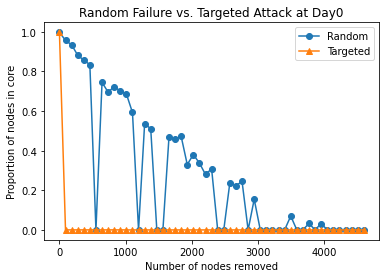

In [62]:
base_year = 2018
year_graph = graphs_by_slaughter_year[base_year]

min_random_nodes, min_attack_nodes = vz.plot_network_robustness(year_graph, attack_specificity=20, plot=True)

# Infection Simulations 

In [96]:
import EoN
import networkx as nx
import matplotlib.pyplot as plt

def prep_EoN_simulation(graph, gamma, beta, sis=True):

    r_0 = beta/gamma
    print("R_naught is", r_0)

    N = graph.number_of_nodes() # population size -  number of cow stop point
    I0 = 0.01  # intial % of infected individuals 
    #initial_infecteds = 1 # initial # of infected 
    R0 = 0
    S0 = N - I0 -R0

    pos = nx.spring_layout(graph)
    nx_kwargs = {"pos": pos, "alpha": 0.7} #optional arguments to be passed on to the networkx plotting command.
    # unable commands "with_labels":True, "width": edgewidth, 

    if sis: 
        print("doing SIS simulation")
        sim_sis = EoN.fast_SIS(graph, tau = beta, gamma=gamma, rho = I0,  return_full_data=True) # REMOVED WEIGHTS 
        sim_sis.set_pos(pos)
        return sim_sis        

    else: 
        print("doing SIR simulation")
        sim_sir = EoN.fast_SIR(graph, tau = beta, gamma=gamma, rho = I0, return_full_data=True)
        sim_sir.set_pos(pos)
        return sim_sir
    
    
def graph_simulation_progression(simulation, t1, t2, step):    
    for i in range(t1,t2, step):
        simulation.display(time = i, **nx_kwargs)
        plt.axis('off') 
        plt.title("Iteration {}".format(i))
        plt.draw()

# SIS Model

***On the entire network that fed 2018***:

In [ ]:
directed_year_graph = digraph_by_slaughter_year[2018]

gamma = 1  # hyperparameter
beta = 2  # hyperparameter

sim_sis = prep_EoN_simulation(directed_year_graph, gamma, beta, sis=True)

In [ ]:
graph_simulation_progression(sim_sis, 1, 30, 5)

***On the largest community that fed 2018***:

In [97]:
gamma = 1  # hyperparameter
beta = 2  # hyperparameter

sim_sis_lc = prep_EoN_simulation(largest_community_graph, gamma, beta, sis=True)

R_naught is 2.0
doing SIS simulation


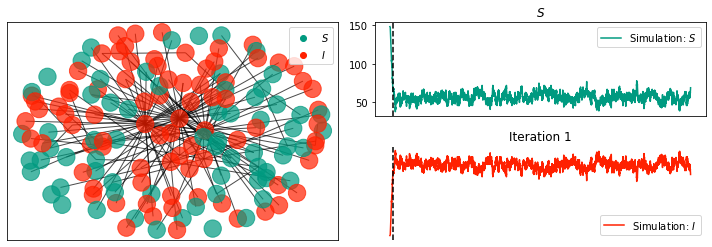

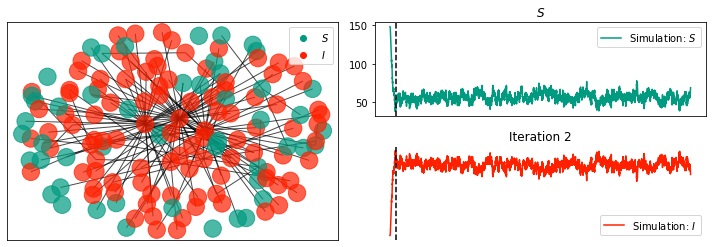

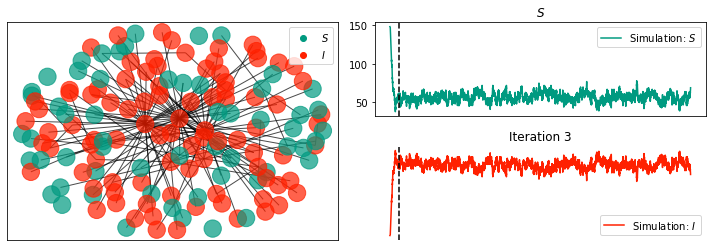

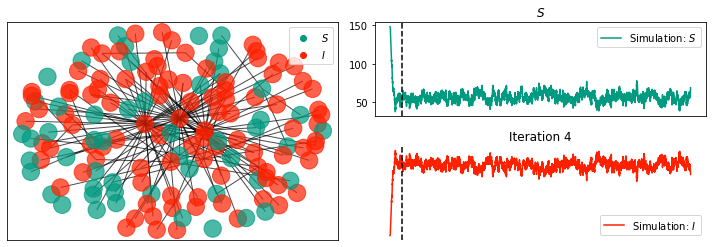

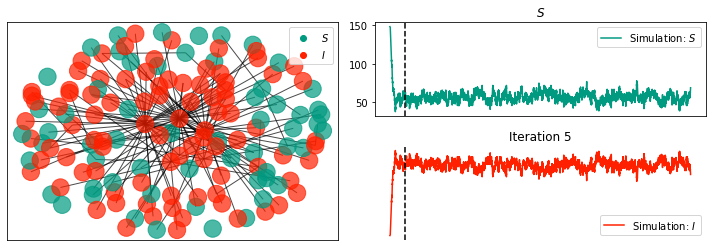

In [98]:
graph_simulation_progression(sim_sis_lc, 0, 6, 1)

# SIR Model

***On the entire network that fed 2018***:

In [ ]:
gamma = 0.5  # hyperparameter
beta = 1  # hyperparameter

sim_sir = prep_EoN_simulation(directed_year_graph, gamma, beta, sis=False)

In [ ]:
graph_simulation_progression(sim_sis, 1, 30, 5)

***On the largest community that fed 2018***:

In [87]:
gamma = 0.5  # hyperparameter
beta = 1  # hyperparameter

sim_sir_lc = prep_EoN_simulation(largest_community_graph, gamma, beta, sis=False)

R_naught is 2.0
doing SIR simulation


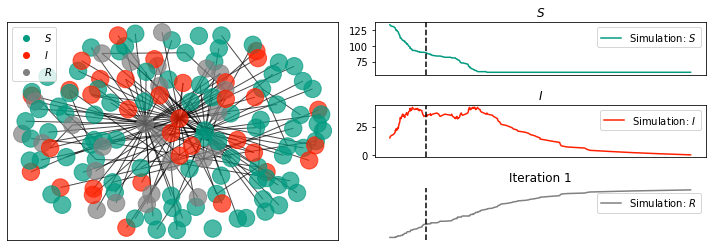

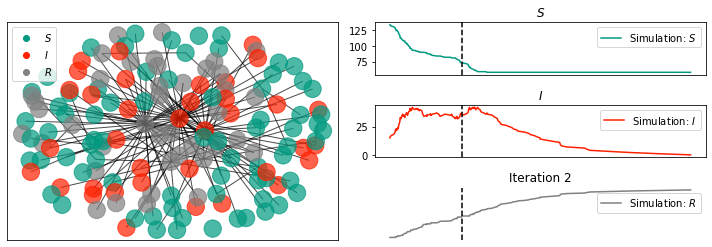

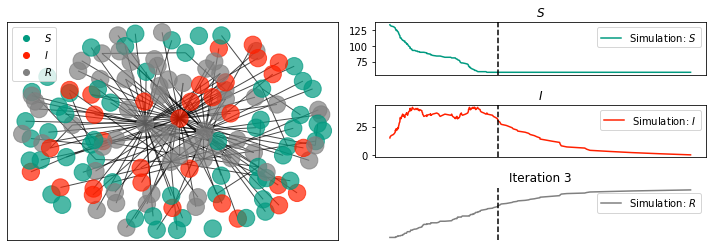

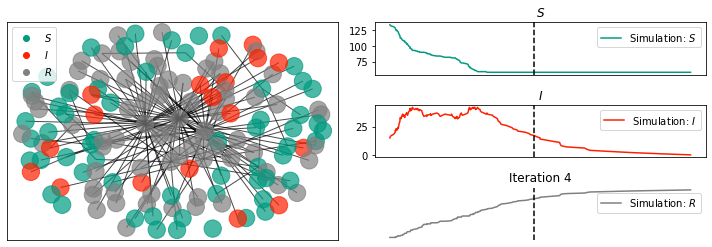

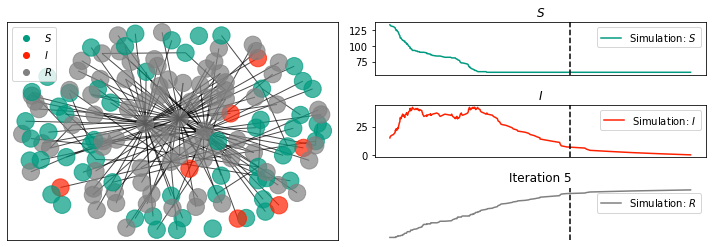

In [89]:
graph_simulation_progression(sim_sir_lc, 1, 6, 1)